In [132]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # split on train and test

# Чтобы выбросы удалить
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Стандартизация
from sklearn.preprocessing import StandardScaler

# Сжатие данных
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    HistGradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.inspection import permutation_importance

# Структура модулей:

 ✅ Предобработка признаков:

* Нормализация по медиане (по строкам)
* Логарифмирование
* Стандартизация
* Взвешивание по встречаемости ?

✅ Обнаружение выбросов + визуализация:

* IsolationForest, OneClassSVM, LOF
* Совместная визуализация (с class)

✅ Модуль обучения моделей + отчётность:

* Несколько моделей: RandomForest, LogReg, SVC, XGBoost,Bagging, GradientBoosting
* Метрики + кросс-валидация
* Feature Importance с отсечкой по резкому падению важности

✅ Визуализация признаков (dim. reduction):

* PCA, LDA, NCA, t-SNE
* С визуальной разбивкой по классам
* Возврат фрейма с важными признаками

# Подгружаем данные

In [202]:
df = pd.read_excel('for_stat.xlsx')

In [203]:
matrix = pd.read_excel('with_name_and_ri.xlsx')

In [204]:
df = df.fillna(0)
matrix = matrix.fillna(0)

In [206]:
matrix

,Name_spb,ID_metabolites_spb,rt(min)_spb,RI_spb,MF_spb,RMF_spb,1 marble fungi 04 22,1 marble fungi 09 22,1 mr fungi 30 30 06 22,1 mr fungi 30 30 2 06 22,...,kirovsk 8a.CDF,kirovsk 9.CDF,kirovsk 10.CDF,RI_calc_kirovsk,features,max_mf,features_id,city,id_metab_city,amount
0,Mannose (P) II,166,25.721250,2065.518789,867,917,22302.277641,134609.971861,317944.070697,571679.729345,...,4.022873e+06,0.000000,0.000000,1954.483734,Mannose (P) II,931,1,kirovsk,281,3
1,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,1.588793e+05,26731.489611,123477.679407,1784.906179,Ribose (4/4),739,2,kirovsk,142,2
2,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,1.909006e+05,3160.759061,36876.250833,3417.650537,Maltose,818,3,kirovsk,241,2
3,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,7.043296e+05,14456.685748,150133.557536,3377.454255,Maltose,863,4,kirovsk,292,2
4,Cholesterol trimethylsilyl ether,136,41.231833,3370.906571,781,818,86021.384697,136.908457,75859.529245,107828.696149,...,5.385748e+04,18331.764009,130271.005822,3155.884005,Cholesterol trimethylsilyl ether,781,5,spb,136,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,Raffinose,772,329,tomsk,186,1
329,".psi.,.psi.-Carotene, 1,1',2,2'-tetrahydro-1,1...",185,43.365517,3577.027258,760,762,142050.413834,1341.830602,67281.028794,50431.100521,...,0.000000e+00,0.000000,0.000000,0.000000,".psi.,.psi.-Carotene, 1,1',2,2'-tetrahydro-1,1...",760,330,spb,185,1
330,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,"M000796_A296005-101-xxx_NA_2953,53_TRUE_VAR5_A...",566,331,ural,140,1
331,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,...,2.095683e+06,68097.389873,0.000000,2015.828290,"cis-9-Hexadecenoic acid, trimethylsilyl ester",936,332,kirovsk,152,1


# Фильтр в зависимости от встречаемости и деление на X и y:

In [300]:
def prepare_filtered_data(df, matrix, amount_threshold=2):
    """
    Фильтрует признаки по threshold значению 'amount' из matrix,
    и оставляет только соответствующие признаки + метки классов из df.

    Parameters:
    - df: DataFrame с признаками (столбцы — номера признаков)
    - matrix: DataFrame с метаинформацией по признакам (содержит 'features_id', 'amount')
    - amount_threshold: float, минимальный порог для 'amount'

    Returns:
    - X: DataFrame с отфильтрованными признаками
    - y: Series с метками классов
    - df_filtered: DataFrame с признаками + метками ('class', 'name_class')
    """
    # Копия исходного df
    df_copy = df.copy()

    # Фильтрация matrix по amount
    matrix_filtered = matrix[matrix['amount'] >= amount_threshold]

    # Приводим к строковому формату
    df_copy.columns = df_copy.columns.astype(str)
    features_to_keep = matrix_filtered['features_id'].astype(str).tolist()

    # Добавляем метки классов
    required_columns = ['class', 'name_class']
    existing_required = [col for col in required_columns if col in df_copy.columns]

    # Формируем финальный список колонок
    final_columns = existing_required + [col for col in features_to_keep if col in df_copy.columns]

    # Фильтрация
    df_filtered = df_copy[final_columns]

    # Разделяем X и y
    X = df_filtered.drop(columns=[col for col in ['class', 'name_class'] if col in df_filtered.columns])
    y = df_filtered['class'] if 'class' in df_filtered.columns else None

    return X, y, df_filtered, matrix_filtered


In [301]:
X, y, df_filtered, matrix_filtered = prepare_filtered_data(df, matrix, amount_threshold=2)

In [302]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Columns: 101 entries, class to 319
dtypes: float64(99), int64(1), object(1)
memory usage: 60.1+ KB


Предобработка без разделения:

In [303]:
def preprocess_features(X, matrix=None,
                        normalize_median=True,
                        log_transform=True,
                        standardize=True,
                        apply_weights=False):
    """
    Универсальная предобработка матрицы признаков.
    Параметры:
        - normalize_median: нормализация по медиане (по строкам)
        - log_transform: логарифмирование (log1p)
        - standardize: стандартизация (z-score)
        - apply_weights: умножить на log-весы признаков по встречаемости
        - matrix: таблица с колонкой 'features_id' и 'amount' (если apply_weights=True)
    Возвращает:
        - X_processed: np.array
        - weights_used: веса признаков или None
    """
    X_processed = X.copy()

    if normalize_median:
        medians = X_processed.median(axis=1).replace(0, 1e-10)
        X_processed = X_processed.div(medians, axis=0)

    if log_transform:
        X_processed = np.log1p(X_processed)

    if standardize:
        scaler = StandardScaler()
        X_processed = scaler.fit_transform(X_processed)

    weights_used = None
    if apply_weights and matrix is not None:
        weights = np.log2(matrix.set_index('features_id')['amount'] + 1)
        # Совпадение по индексам
        weights = weights.reindex(X.columns.astype(int)).fillna(1).values
        X_processed = X_processed * weights
        weights_used = weights

    return X_processed, weights_used


In [304]:
X_processed, weights_used = preprocess_features(X, matrix=None, normalize_median=True, log_transform=True, standardize=True, apply_weights=False)

Обработка разделенных данных:

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [306]:
def preprocess_train_test(X_train, X_test, matrix=None,
                         normalize_median=True,
                         log_transform=True,
                         standardize=True,
                         apply_weights=False):
    """
    Предобработка X_train и X_test с сохранением структуры DataFrame.

    Параметры:
        - normalize_median: нормализация по медиане (по строкам)
        - log_transform: log1p
        - standardize: стандартизация (fit на train, transform на test)
        - apply_weights: логарифмические веса (по amount из matrix)

    Возвращает:
        - X_train_processed: pd.DataFrame
        - X_test_processed: pd.DataFrame
        - weights_used: np.array или None
    """

    # Приводим к DataFrame, если на вход подан np.ndarray
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test)

    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()

    # Нормализация по медиане (по строкам)
    if normalize_median:
        med_train = X_train_proc.median(axis=1).replace(0, 1e-10)
        X_train_proc = X_train_proc.div(med_train, axis=0)

        med_test = X_test_proc.median(axis=1).replace(0, 1e-10)
        X_test_proc = X_test_proc.div(med_test, axis=0)

    # Логарифмирование
    if log_transform:
        X_train_proc = np.log1p(X_train_proc)
        X_test_proc = np.log1p(X_test_proc)

    # Стандартизация: fit на train
    weights_used = None
    if standardize:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_proc)
        X_test_scaled = scaler.transform(X_test_proc)
        X_train_proc = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_proc = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Применение логарифмических весов (если указано)
    if apply_weights and matrix is not None:
        weights = np.log2(matrix.set_index('features_id')['amount'] + 1)
        weights = weights.reindex(X_train.columns.astype(int)).fillna(1).values

        X_train_proc = X_train_proc * weights
        X_test_proc = X_test_proc * weights
        weights_used = weights

    return X_train_proc, X_test_proc, weights_used

In [307]:
X_train, X_test, weights = preprocess_train_test(X_train, X_test, matrix= matrix, normalize_median=True, log_transform=True, standardize=True, apply_weights=False)

# Выбросы

In [308]:
def detect_outliers(X, df_meta, contamination=0.1, nu=0.1, vote_threshold=2):
    from sklearn.ensemble import IsolationForest
    from sklearn.svm import OneClassSVM
    from sklearn.neighbors import LocalOutlierFactor

    iso = IsolationForest(contamination=contamination, random_state=42)
    svm = OneClassSVM(nu=nu)
    lof = LocalOutlierFactor(novelty=True)

    iso.fit(X)
    svm.fit(X)
    lof.fit(X)

    df_meta = df_meta.copy()
    df_meta['iso'] = iso.predict(X)
    df_meta['svm'] = svm.predict(X)
    df_meta['lof'] = lof.predict(X)
    df_meta['votes'] = (df_meta[['iso', 'svm', 'lof']] == -1).sum(axis=1)
    df_meta['final_outlier'] = df_meta['votes'].apply(lambda x: -1 if x >= vote_threshold else 1)

    print(f"🔍 Найдено выбросов: {(df_meta['final_outlier'] == -1).sum()} из {len(df_meta)}")

    return df_meta

Визуализация выбросов:
Подсвечивает выбросы
* чёрным (-1)

Цвета классов:

1 — жёлтый

2 — зелёный

3 — синий

4 — красный

In [309]:
def visualize_outliers(X, outlier_labels, class_labels=None, method='PCA'):
    """
    Визуализация выбросов и классов на 2D-графике после понижения размерности.

    Параметры:
    - X: данные (np.array или DataFrame)
    - outlier_labels: массив (-1 для выбросов, 1 для нормальных точек)
    - class_labels: метки классов (целые), можно не указывать
    - method: 'PCA' или 'TSNE'
    """
    # Понижение размерности
    if method == 'PCA':
        reducer = PCA(n_components=2, random_state=42)
        reduced = reducer.fit_transform(X)
        explained = reducer.explained_variance_ratio_.sum()
        print(f"🔹 PCA: объяснённая дисперсия (2 компоненты): {explained:.3f} ({explained*100:.1f}%)")
    elif method == 'TSNE':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
        reduced = reducer.fit_transform(X)
        print("🔹 t-SNE: визуализация в 2D (перспектива локальных расстояний)")
    else:
        raise ValueError("Метод должен быть 'PCA' или 'TSNE'")

    # Подготовка датафрейма
    df_vis = pd.DataFrame(reduced, columns=['Dim1', 'Dim2'])
    df_vis['outlier'] = outlier_labels

    if class_labels is not None:
        df_vis['class'] = class_labels
        df_vis['final_label'] = df_vis.apply(
            lambda r: 'outlier' if r['outlier'] == -1 else r['class'], axis=1
        )
        unique_classes = sorted(pd.Series(class_labels).dropna().unique())
        palette = {c: sns.color_palette("tab10")[i % 10] for i, c in enumerate(unique_classes)}
        palette['outlier'] = 'black'
        hue = 'final_label'
    else:
        hue = 'outlier'
        palette = {-1: 'black', 1: 'gray'}

    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_vis, x='Dim1', y='Dim2', hue=hue, palette=palette, alpha=0.8)
    plt.title(f'{method} — визуализация выбросов и классов')
    plt.grid(True)
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()


In [310]:
df_outliners = detect_outliers(X_processed, df, contamination=0.1, nu=0.1, vote_threshold=2)

🔍 Найдено выбросов: 16 из 76


In [311]:
#df_outliners_1 = df_outliners[(df_outliners['final_outlier'] == 1)&(df_outliners['class'] != 4)]

In [312]:
#X, y, df_filtered, matrix_filtered = prepare_filtered_data(df_outliners_1, matrix, amount_threshold=2)

In [313]:
#X_processed, weights_used = preprocess_features(X, matrix=None, normalize_median=True, log_transform=True, standardize=True, apply_weights=False)

In [314]:
#visualize_outliers(X_processed, df_outliners_1['final_outlier'], class_labels= y, method='PCA')
#visualize_outliers(X_processed, df_outliners_1['final_outlier'], class_labels= y, method='TSNE')

🔹 PCA: объяснённая дисперсия (2 компоненты): 0.591 (59.1%)


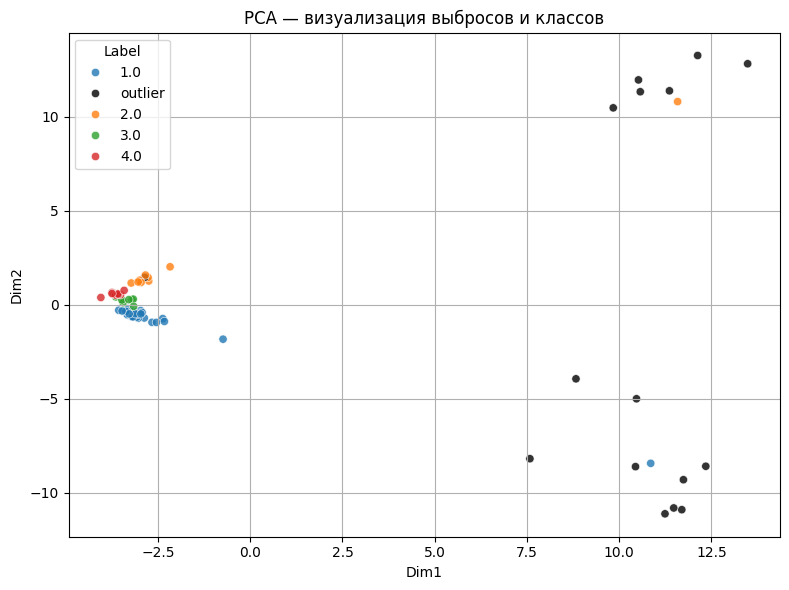

🔹 t-SNE: визуализация в 2D (перспектива локальных расстояний)


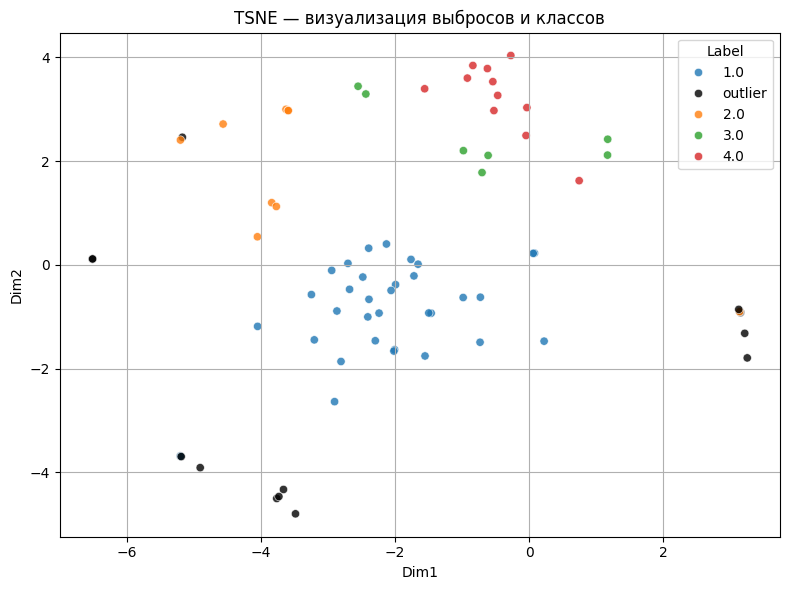

In [315]:
visualize_outliers(X_processed, df_outliners['final_outlier'], class_labels= y, method='PCA')
visualize_outliers(X_processed, df_outliners['final_outlier'], class_labels= y, method='TSNE')

# Обучаем 6 моделей

Функция для извлечения важности признаков:

In [281]:
def get_feature_importance(model, X_val=None, y_val=None):
    """Извлекает важности признаков из модели (если возможно)."""
    # BaggingClassifier: усреднённые важности базовых моделей
    if isinstance(model, BaggingClassifier):
        if hasattr(model, "estimators_") and hasattr(model.estimators_[0], "feature_importances_"):
            return np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
        else:
            return None

    # HistGradientBoostingClassifier
    elif isinstance(model, HistGradientBoostingClassifier):
        if hasattr(model, "feature_importances_"):
            try:
                return model.feature_importances_
            except:
                pass
        # В противном случае: permutation_importance
        if X_val is not None and y_val is not None:
            result = permutation_importance(model, X_val, y_val, n_repeats=5, random_state=42, scoring='accuracy')
            return result.importances_mean
        else:
            return None

    # Остальные модели
    elif hasattr(model, "feature_importances_"):
        return model.feature_importances_
    elif hasattr(model, "coef_"):
        return np.abs(model.coef_).mean(axis=0)

    return None

Обучение, которое возвращает df для каждой модели с важностями признаков

In [282]:
def train_and_evaluate_models_extended_from_split(X_train, X_test, y_train, y_test, matrix=None, random_state=42):
    # Определяем модели
    models = {
        'Random Forest': RandomForestClassifier(max_depth=5, random_state=random_state),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
        'Bagging': BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=4, random_state=random_state),
            n_estimators=10,
            random_state=random_state
        ),
        'HistGradientBoosting': HistGradientBoostingClassifier(random_state=random_state),
        'SVM': SVC(kernel='rbf', probability=True, random_state=random_state)
    }

    results = {}
    feature_dfs = {}

    for name, model in models.items():
        print(f"\n🔍 Обучаем модель: {name}")

        # Преобразуем y, если это XGBoost или SVM
        if name in ['XGBoost', 'SVM']:
            le = LabelEncoder()
            y_train_enc = le.fit_transform(y_train)
            y_test_enc = le.transform(y_test)
            model.fit(X_train, y_train_enc)
            y_pred = model.predict(X_test)
            y_pred = le.inverse_transform(y_pred)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        scores = {
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted')
        }

        print(f"🎯 Результаты: { {k: round(v, 3) for k, v in scores.items()} }")

        importances = get_feature_importance(model, X_test, y_test)

        if importances is not None:
            # Обеспечиваем полный список важностей
            full_importances = np.zeros(X_train.shape[1])
            length = min(len(importances), X_train.shape[1])
            full_importances[:length] = importances[:length]

            feat_df = pd.DataFrame({
                'feature_id': X_train.columns.astype(int),
                'importance': full_importances
            }).sort_values('importance', ascending=False)

            if matrix is not None:
                feat_df = feat_df.merge(matrix, left_on='feature_id', right_on='features_id', how='left')

            feature_dfs[name] = feat_df.reset_index(drop=True)
        else:
            print(f"⚠️ Модель {name} не поддерживает извлечение важности признаков.")
            feature_dfs[name] = None

        results[name] = {
            'test_scores': scores,
            'feature_importances': feature_dfs[name]
        }

    return (
        feature_dfs.get('Random Forest'),
        feature_dfs.get('Logistic Regression'),
        feature_dfs.get('XGBoost'),
        feature_dfs.get('Bagging'),
        feature_dfs.get('HistGradientBoosting'),
        feature_dfs.get('SVM'),
        feature_dfs,
        results)


In [283]:
rf_df, lr_df, xgb_df, bag_df, hgb_df, _, feature_dfs, results = train_and_evaluate_models_extended_from_split(X_train, X_test, y_train, y_test, random_state=42)


🔍 Обучаем модель: Random Forest
🎯 Результаты: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0, 'recall': 1.0}

🔍 Обучаем модель: Logistic Regression
🎯 Результаты: {'accuracy': 0.968, 'f1': 0.966, 'precision': 0.97, 'recall': 0.968}

🔍 Обучаем модель: XGBoost
🎯 Результаты: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0, 'recall': 1.0}

🔍 Обучаем модель: Bagging
🎯 Результаты: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0, 'recall': 1.0}

🔍 Обучаем модель: HistGradientBoosting
🎯 Результаты: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0, 'recall': 1.0}

🔍 Обучаем модель: SVM
🎯 Результаты: {'accuracy': 0.806, 'f1': 0.749, 'precision': 0.722, 'recall': 0.806}
⚠️ Модель SVM не поддерживает извлечение важности признаков.


Создаем df с пересечениями признаков:
* amount_top_models — сколько моделей включают признак в топе (учитывая важность > 0),

* amount_models — сколько моделей имеют просто важность > 0 для признака.

In [284]:
def analyze_feature_importances(models_dfs, manual_top=None):
    """
    models_dfs: dict {название модели: DataFrame с ['feature_id', 'importance']}.
    manual_top: int или None. Если задано, используется этот размер топа, иначе считается локтевой.

    Функция:
    - Печатает размер топа для каждой модели (локтевой или manual_top).
    - Печатает пересечение и объединение признаков всех моделей.
    - Возвращает объединённый DataFrame с колонками:
      feature_id, importance первой модели, importance_<model2>, ..., amount_top_models, amount_models.
    """
    top_feats = {}
    sizes = {}

    # Проверка пересечений и объединений признаков
    sets = [set(df['feature_id']) for df in models_dfs.values()]
    common_feats = set.intersection(*sets)
    all_feats = set.union(*sets)
    print(f"Общее количество уникальных признаков: {len(all_feats)}")
    print(f"Количество признаков в пересечении всех моделей: {len(common_feats)}")

    for name, df in models_dfs.items():
        df_sorted = df.sort_values(by='importance', ascending=False).reset_index(drop=True)
        imps = df_sorted['importance'].values
        if manual_top is not None:
            top_n = manual_top
        else:
            if len(imps) > 1:
                ratios = imps[:-1] / (imps[1:] + 1e-10)
                top_n = int(ratios.argmax()) + 1  # +1 чтобы включить индекс локтя
            else:
                top_n = len(imps)
        top_list = df_sorted.loc[:top_n - 1, 'feature_id'].tolist()
        top_feats[name] = set(df[(df['importance'] > 0) & (df['feature_id'].isin(top_list))]['feature_id'])
        sizes[name] = len(top_feats[name])

    for name, size in sizes.items():
        print(f"Модель {name}: размер топа = {size}")
    avg_size = sum(sizes.values()) / len(sizes) if sizes else 0
    print(f"Средний размер топа: {avg_size:.2f}")

    model_names = list(models_dfs.keys())
    if not model_names:
        return pd.DataFrame()

    merged_df = models_dfs[model_names[0]].copy()
    for name in model_names[1:]:
        df_other = models_dfs[name][['feature_id', 'importance']].copy()
        df_other = df_other.rename(columns={'importance': f'importance_{name}'})
        merged_df = pd.merge(merged_df, df_other, on='feature_id', how='outer')

    def count_in_tops(fid):
        return sum(fid in top_feats[m] for m in model_names)

    def count_nonzero(fid):
        count = 0
        for name in model_names:
            col = 'importance' if name == model_names[0] else f'importance_{name}'
            val = merged_df.loc[merged_df['feature_id'] == fid, col]
            if not val.empty and val.values[0] > 0:
                count += 1
        return count

    merged_df['amount_top_models'] = merged_df['feature_id'].apply(count_in_tops)
    merged_df['amount_models'] = merged_df['feature_id'].apply(count_nonzero)

    return merged_df



In [285]:
models = {'Random_forest': rf_df, 'Log_reg': lr_df, 'XGBoost': xgb_df,'Bagging': bag_df,'HistGradientBoosting': hgb_df}

result_df = analyze_feature_importances(models)

Общее количество уникальных признаков: 99
Количество признаков в пересечении всех моделей: 99
Модель Random_forest: размер топа = 84
Модель Log_reg: размер топа = 14
Модель XGBoost: размер топа = 11
Модель Bagging: размер топа = 20
Модель HistGradientBoosting: размер топа = 1
Средний размер топа: 26.00


In [298]:
result_df_max = result_df[result_df['amount_top_models'] >= 2]
result_df_max.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 1 to 97
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   features_id                      36 non-null     int64  
 1   importance                       36 non-null     float64
 2   importance_Log_reg               36 non-null     float64
 3   importance_XGBoost               36 non-null     float64
 4   importance_Bagging               36 non-null     float64
 5   importance_HistGradientBoosting  36 non-null     float64
 6   amount_top_models                36 non-null     int64  
 7   amount_models                    36 non-null     int64  
dtypes: float64(5), int64(3)
memory usage: 2.5 KB


Создаем общий df с признаками

In [286]:
result_df = result_df.rename(columns={'feature_id': 'features_id'})

In [287]:
def join_tables(df1, df2, name1='df1', name2='df2'):
    res = pd.merge(df1,df2,on='features_id',how='outer',suffixes=(f'_{name1}', f'_{name2}'))
    res = res.fillna(0)
    return res

In [288]:
res = join_tables(matrix, result_df, name1='matrix', name2='models')

In [299]:
res.to_excel('result_with_models.xlsx', index=False)

# Визуализация:

In [251]:
def visualize_reduction(X, y, method='PCA', n_components=2):
    from sklearn.decomposition import PCA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
    from sklearn.manifold import TSNE
    from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA

    method = method.upper()
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
    elif method == 'LDA':
        reducer = LDA(n_components=min(n_components, len(np.unique(y)) - 1))
    elif method == 'NCA':
        reducer = NCA(n_components=n_components, random_state=42)
    elif method == 'TSNE':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError(f"Метод {method} не поддерживается")

    X_reduced = reducer.fit_transform(X, y) if method != 'TSNE' else reducer.fit_transform(X)
    df_vis = pd.DataFrame(X_reduced, columns=[f'Comp{i+1}' for i in range(n_components)])
    df_vis['class'] = y

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_vis, x='Comp1', y='Comp2', hue='class', palette='Set2', alpha=0.8)
    plt.title(f'{method} визуализация')
    plt.grid(True)
    plt.show()


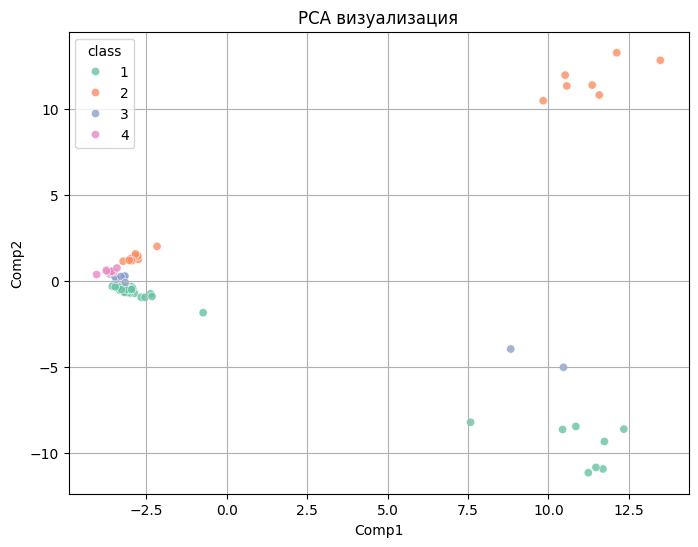

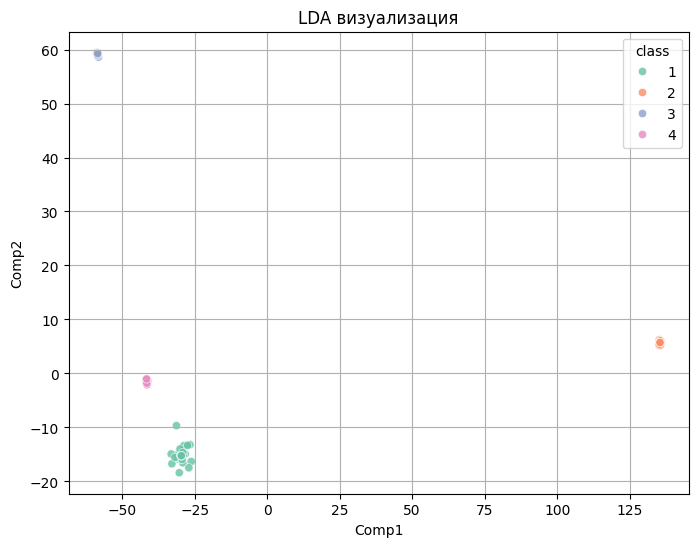

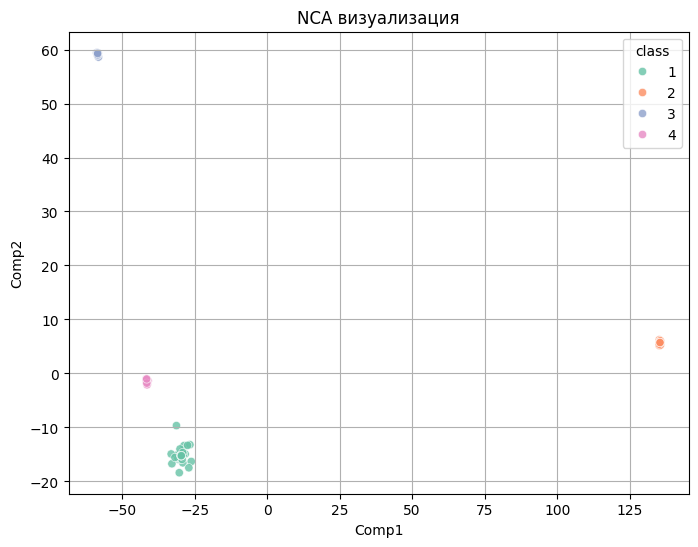

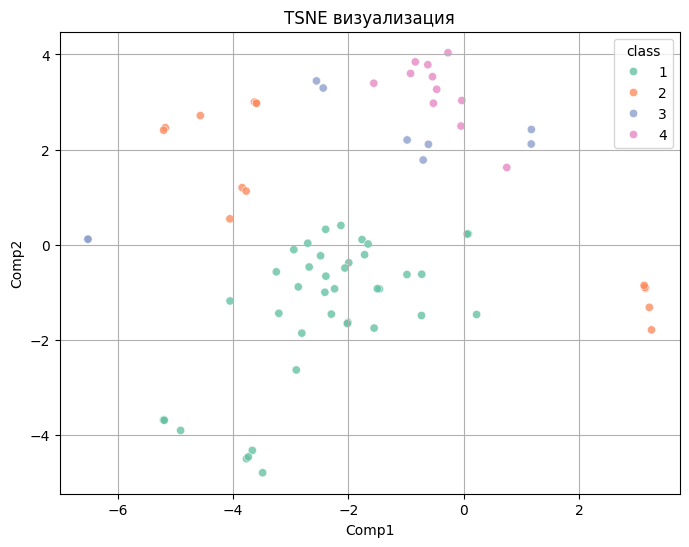

In [252]:
visualize_reduction(X_processed, y, method='PCA', n_components=3)
visualize_reduction(X_processed, y, method='LDA', n_components=2)
visualize_reduction(X_processed, y, method='NCA', n_components=2)
visualize_reduction(X_processed, y, method='TSNE', n_components=2)

# PCA

In [253]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_feature_weights(X, matrix, n_components=3, scale_data=True, top_n=100):
    """
    PCA-анализ признаков с выводом веса компонент и распределения по amount.

    :param X: DataFrame с числовыми признаками
    :param matrix: DataFrame, содержащий информацию о признаках (features_id, features, amount и т.д.)
    :param n_components: Количество главных компонент
    :param scale_data: Применять ли StandardScaler перед PCA
    :param top_n: Сколько самых весомых признаков анализировать для каждой PC
    :return: DataFrame с весами компонент и метаданными
    """
    if scale_data:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.values

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Веса (loadings)
    loadings = pd.DataFrame(
        pca.components_.T,
        index=X.columns.astype(int),
        columns=[f'PC{i+1}' for i in range(n_components)]
    ).reset_index().rename(columns={'index': 'features_id'})

    # Объединяем с метаинформацией
    matrix = matrix.reset_index(drop=True)
    loadings_merged = loadings.merge(matrix, on='features_id', how='left')

    # Вывод дисперсии
    explained = pca.explained_variance_ratio_.sum()
    print(f"\n📈 Объяснённая дисперсия ({n_components} компонент): {explained:.2%}")

    for i in range(n_components):
        col = f'PC{i+1}'
        print(f"\n🔍 Анализ компоненты {col} (топ-{top_n} признаков по модулю веса):")

        # Топ-N по модулю веса
        top_features = loadings_merged[['features_id', col, 'features', 'amount']].copy()
        top_features['abs_weight'] = top_features[col].abs()
        top_n_df = top_features.sort_values('abs_weight', ascending=False).head(top_n)

        # Распределение по amount
        amount_dist = top_n_df['amount'].value_counts().sort_index()

        print("📊 Распределение по 'amount':")
        for amt, count in amount_dist.items():
            print(f"  amount = {amt}: {count} признаков")

    return loadings_merged


In [263]:
loadings_df = pca_feature_weights(X, matrix, n_components=10)


📈 Объяснённая дисперсия (10 компонент): 80.42%

🔍 Анализ компоненты PC1 (топ-100 признаков по модулю веса):
📊 Распределение по 'amount':
  amount = 2: 65 признаков
  amount = 3: 20 признаков
  amount = 4: 14 признаков

🔍 Анализ компоненты PC2 (топ-100 признаков по модулю веса):
📊 Распределение по 'amount':
  amount = 2: 65 признаков
  amount = 3: 20 признаков
  amount = 4: 14 признаков

🔍 Анализ компоненты PC3 (топ-100 признаков по модулю веса):
📊 Распределение по 'amount':
  amount = 2: 65 признаков
  amount = 3: 20 признаков
  amount = 4: 14 признаков

🔍 Анализ компоненты PC4 (топ-100 признаков по модулю веса):
📊 Распределение по 'amount':
  amount = 2: 65 признаков
  amount = 3: 20 признаков
  amount = 4: 14 признаков

🔍 Анализ компоненты PC5 (топ-100 признаков по модулю веса):
📊 Распределение по 'amount':
  amount = 2: 65 признаков
  amount = 3: 20 признаков
  amount = 4: 14 признаков

🔍 Анализ компоненты PC6 (топ-100 признаков по модулю веса):
📊 Распределение по 'amount':
  amoun